In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import TFBertForSequenceClassification, BertTokenizer, AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

import sys
sys.path.append("..")
import utils.utils as utils
import utils.postprocessing_utils as post_utils
from data_preparation.data_preparation_sentiment import Example, convert_examples_to_tf_dataset, make_batches

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Training Data Size vs Within-Language Performance](#A1)

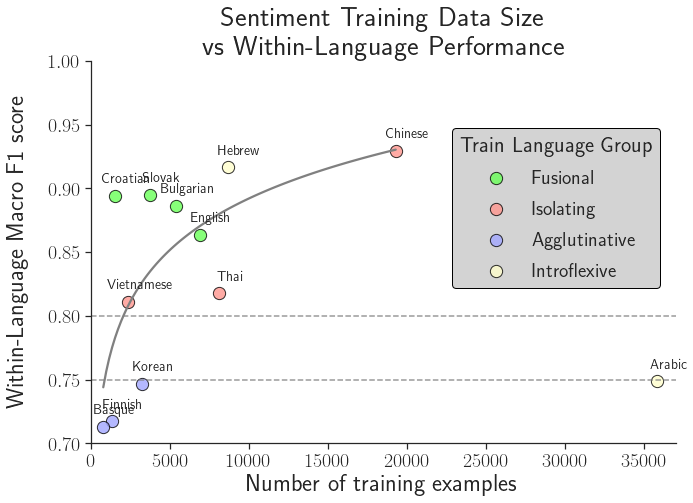

[A.2. Average length vs Within-Language Performance](#A2)

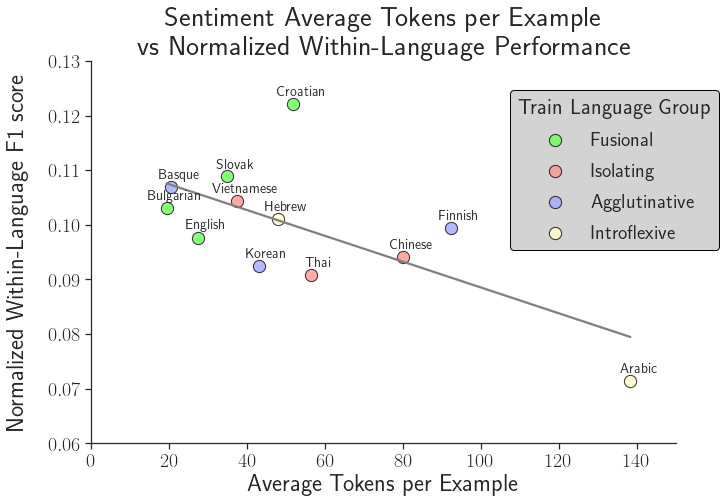

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Training Data Size vs Within-Language Performance

In [3]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
df = results["Macro_F1"]["langvlang"].iloc[:12]

In [4]:
basic_stats = pd.read_excel("../data_exploration/sentiment_basic_stats.xlsx")

In [5]:
df = pd.DataFrame({"Train-Group": df["Group"], "Train-Language": df["Test\Train"], 
                   "Within-F1": np.diagonal(df.iloc[:, 2:-1].values)})

In [6]:
df = pd.merge(df, basic_stats[["language", "train_examples"]], how="left", left_on="Train-Language", right_on="language")

In [7]:
pearsonr(x=np.log(df.loc[df["Train-Language"] != "Arabic", "train_examples"]), 
         y=df.loc[df["Train-Language"] != "Arabic", "Within-F1"])

(0.6948126770203266, 0.017643848847942328)

In [8]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

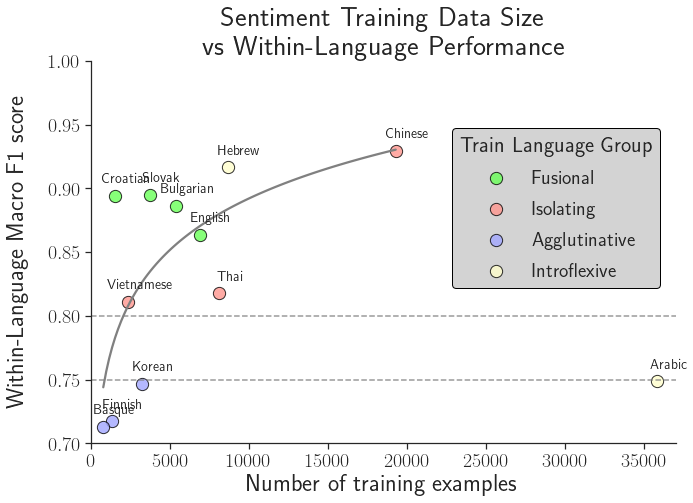

In [9]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="train_examples", y="Within-F1", data=df, hue="Train-Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="train_examples", y="Within-F1", data=df[df["Train-Language"] != "Arabic"], scatter=False, 
            color="grey", ci=None, logx=True)

for i, row in df.iterrows():
    plt.text(row["train_examples"] + 700, row["Within-F1"] + 0.01, row["Train-Language"], fontsize=14, 
             horizontalalignment="center")
    
plt.axhline(0.8, color="grey", linestyle="--", alpha=0.8)
plt.axhline(0.75, color="grey", linestyle="--", alpha=0.8)

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.6, 0.85), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((0.7,1))
plt.xlim((0,37000))
plt.ylabel("Within-Language Macro F1 score", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of training examples", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Training Data Size \n vs Within-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_size_vs_within_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A2"></a>

[Back to contents](#index)

### A.2. Average length vs Within-Language Performance

In [323]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
df = results["Macro_F1"]["langvlang"].iloc[:12]

In [324]:
basic_stats = pd.read_excel("../data_exploration/sentiment_basic_stats.xlsx")

In [325]:
df = pd.DataFrame({"Train-Group": df["Group"], "Train-Language": df["Test\Train"], 
                   "Within-F1": np.diagonal(df.iloc[:, 2:-1].values)})

In [326]:
df = pd.merge(df, basic_stats[["language", "test_avg_tokens", "train_examples"]], how="left", 
              left_on="Train-Language", right_on="language")

No clear correlation

In [327]:
pearsonr(x=df["test_avg_tokens"], y=df["Within-F1"])

(-0.2713491439907264, 0.39359036173010087)

In [328]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

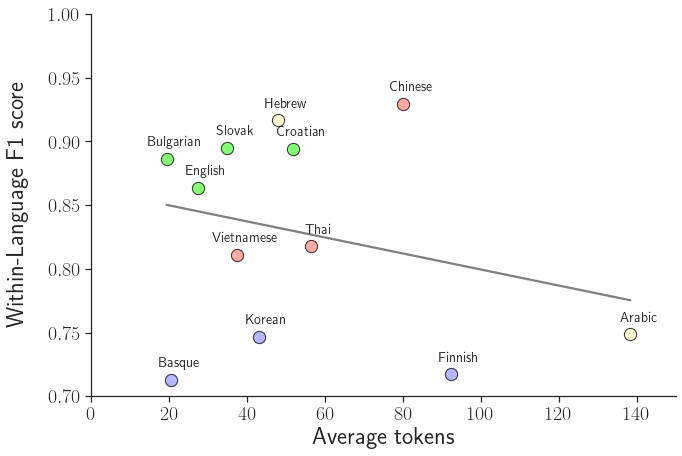

In [132]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="test_avg_tokens", y="Within-F1", data=df, hue="Train-Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="test_avg_tokens", y="Within-F1", data=df, scatter=False, 
            color="grey", ci=None)

for i, row in df.iterrows():
    plt.text(row["test_avg_tokens"] + 2, row["Within-F1"] + 0.01, row["Train-Language"], fontsize=14, 
             horizontalalignment="center")

# plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
#            bbox_to_anchor=(0.6, 0.85), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
#            framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((0.7,1))
plt.xlim((0,150))
plt.ylabel("Within-Language F1 score", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Average tokens", fontsize=24 +  extra_fontsize)
# plt.title("Sentiment Training Data Size \n vs Within-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_size_vs_within_f1.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [329]:
df["Normalized-Within-F1"] = df["Within-F1"] / np.log(df["train_examples"])

In [330]:
pearsonr(x=df["test_avg_tokens"], y=df["Normalized-Within-F1"])

(-0.6675408023537927, 0.017696059207645377)

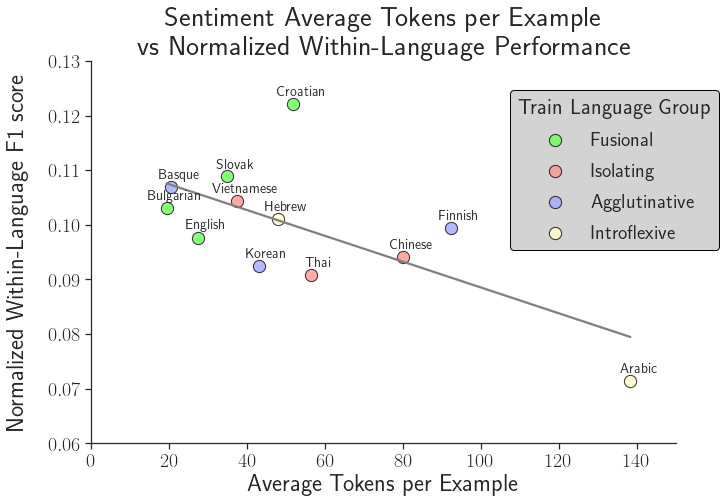

In [331]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="test_avg_tokens", y="Normalized-Within-F1", data=df, hue="Train-Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="test_avg_tokens", y="Normalized-Within-F1", data=df, scatter=False, 
            color="grey", ci=None)

for i, row in df.iterrows():
    plt.text(row["test_avg_tokens"] + 2, row["Normalized-Within-F1"] + 0.0015, row["Train-Language"], fontsize=14, 
             horizontalalignment="center")

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((0.06,0.13))
plt.xlim((0,150))
plt.ylabel("Normalized Within-Language F1 score", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Average Tokens per Example", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Average Tokens per Example \n vs Normalized Within-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_tokens_vs_norm_within_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()